In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from dataloader import TRAILDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Functions

In [3]:
def create_sequences(data, input_length=14, output_length=4):
    X, y = [], []
    for i in tqdm(range(0,len(data) - input_length - output_length + 1,output_length), desc="Generating sequences"):
        X.append(data[i:i+input_length])
        y.append(data[i+input_length:i+input_length+output_length])
    return np.array(X), np.array(y)


In [4]:
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def nmse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2) / torch.mean(y_true ** 2)

def mape(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc='Training',position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss = validate_model(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    print('Finished Training')
    
    return train_losses, val_losses


In [7]:
def denorm_tensor(x, min_, max_):
    return x * (max_ - min_) + min_

In [8]:
def test_model(model, test_loader, predict_scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # apply reverse scaling
            max_ = torch.tensor(predict_scaler.data_max_).to(device)
            min_ = torch.tensor(predict_scaler.data_min_).to(device)
            
            y_batch_ = denorm_tensor(y_batch, min_, max_)
            outputs_ = denorm_tensor(outputs, min_, max_)
        
            y_true.append(y_batch_)
            y_pred.append(outputs_)
    
    
    y_true = [tensor.cpu().numpy() for tensor in y_true]
    y_pred = [tensor.cpu().numpy() for tensor in y_pred]
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    mse_per_output = []
    rmse_per_output = []
    mape_per_output = []
    
    for i in range(y_true.shape[1]):
        mse_value = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse_value = np.sqrt(mse_value)
        mape_value = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])

        mse_per_output.append(mse_value)
        rmse_per_output.append(rmse_value)
        mape_per_output.append(mape_value)

        print(f"Output {i+1}: MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}, MAPE: {mape_value:.4f}%")
        
    
    return mse_per_output, rmse_per_output, mape_per_output

In [9]:
def get_predictions(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    return y_true, y_pred

In [10]:
def plot_true_vs_predicted(y_true, y_pred, time=None):
    if time is None:
        time = np.arange(len(y_true))
    
    plt.figure(figsize=(18, 6))
    plt.plot(time, y_true, color='blue', label='True Values')#, linestyle='-', marker='o')
    plt.plot(time, y_pred, color='red', label='Predicted Values')#, linestyle='--', marker='x')
    
    #plt.xlabel('Time')
    plt.ylabel('Total Load')
    plt.title('True Values vs Predicted Values')
    plt.legend()
    plt.show()


In [11]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


MLP

In [12]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.sigmoid(self.fc3(x)) 
        return x


In [14]:
LAG = 4 * 24
HORIZON = 4
LEARNING_RATE = 0.003
EPOCHS = 30
BATCH_SIZE = 128

Loading the data and splitting it into training, validation, and test sets

In [15]:
csv_file = "Processed_data.csv"
df = pd.read_csv(csv_file, sep=",") 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [16]:
df_train = df[df["Year"] < 2022]
df_val = df[df["Year"] == 2022]
df_test = df[df["Year"] == 2023]

In [17]:
# Final test set

df.iloc[335428 : 338404].to_csv('truth.csv', index = False)

df_final_test = df.iloc[335428-LAG : 338404]

In [18]:
columns_input = ['Total Load Interpolated']  
column_to_predict = 'Total Load Interpolated'
column_to_normalize = ['Total Load Interpolated']

In [19]:
#train_datasetset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize, scaler=StandardScaler(), predict_scaler=StandardScaler())
train_dataset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize)

scaler = train_dataset.get_scaler()
predict_scaler = train_dataset.get_predict_scaler()

train_dataset.save_scaler()

predict_scaler = train_dataset.get_predict_scaler()
print("train dataset loaded")
print(column_to_normalize)

val_dataset = TRAILDataset(df_val, len(df_val), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("validation dataset loaded")

test_dataset = TRAILDataset(df_test, len(df_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("test dataset loaded")



final_test_dataset = TRAILDataset(df_final_test, len(df_final_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("final test dataset loaded")


train dataset loaded
['Total Load Interpolated']
validation dataset loaded
test dataset loaded
final test dataset loaded


c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sequence generation

In [20]:
X_train, y_train = create_sequences(train_dataset.data['Total Load Interpolated'], input_length=LAG, output_length=HORIZON)
X_val, y_val = create_sequences(val_dataset.data['Total Load Interpolated'], input_length=LAG, output_length=HORIZON)
X_test, y_test = create_sequences(test_dataset.data['Total Load Interpolated'], input_length=LAG, output_length=HORIZON)

X_final_test, y_final_test = create_sequences(final_test_dataset.data['Total Load Interpolated'], input_length=LAG, output_length=HORIZON)

Generating sequences: 100%|██████████| 744/744 [00:00<00:00, 11337.15it/s]


In [21]:
train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32).view(-1, LAG), 
                                   torch.tensor(y_train, dtype=torch.float32).view(-1, HORIZON))

val_dataset = data.TensorDataset(torch.tensor(X_val, dtype=torch.float32).view(-1, LAG), 
                                 torch.tensor(y_val, dtype=torch.float32).view(-1, HORIZON))

test_dataset = data.TensorDataset(torch.tensor(X_test, dtype=torch.float32).view(-1, LAG), 
                                  torch.tensor(y_test, dtype=torch.float32).view(-1, HORIZON))



final_test_dataset = data.TensorDataset(torch.tensor(X_final_test, dtype=torch.float32).view(-1, LAG), 
                                  torch.tensor(y_final_test, dtype=torch.float32).view(-1, HORIZON))

In [22]:
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

final_test_loader = data.DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Model creation and training

In [ ]:
# MLP
model =  MLPRegressor(input_size=LAG, output_size=HORIZON)


In [24]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

Training:   0%|          | 0/480 [00:00<?, ?it/s]C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1/30, Training Loss: 0.0200, Validation Loss: 0.0097


Epoch 2/30, Training Loss: 0.0037, Validation Loss: 0.0019


Epoch 3/30, Training Loss: 0.0016, Validation Loss: 0.0016


Epoch 4/30, Training Loss: 0.0011, Validation Loss: 0.0011


Epoch 5/30, Training Loss: 0.0009, Validation Loss: 0.0009


Epoch 6/30, Training Loss: 0.0008, Validation Loss: 0.0008


Epoch 7/30, Training Loss: 0.0007, Validation Loss: 0.0008


Epoch 8/30, Training Loss: 0.0007, Validation Loss: 0.0008


Epoch 9/30, Training Loss: 0.0007, Validation Loss: 0.0008


Epoch 10/30, Training Loss: 0.0007, Validation Loss: 0.0008


Epoch 11/30, Training Loss: 0.0006, Validation Loss: 0.0008


Epoch 12/30, Training Loss: 0.0006, Validation Loss: 0.0008


Epoch 13/30, Training Loss: 0.0006, Validation Loss: 0.0007


Epoch 14/30, Training Loss: 0.0006, Validation Loss: 0.0007


Epoch 15/30, Training Loss: 0.0006, Validation Loss: 0.0007


Epoch 16/30, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 17/30, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 18/30, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 19/30, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 20/30, Training Loss: 0.0005, Validation Loss: 0.0005


Epoch 21/30, Training Loss: 0.0005, Validation Loss: 0.0005


Epoch 22/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 23/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 24/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 25/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 26/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 27/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 28/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 29/30, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 30/30, Training Loss: 0.0004, Validation Loss: 0.0005
Finished Training


#### **Training / Validation curves**

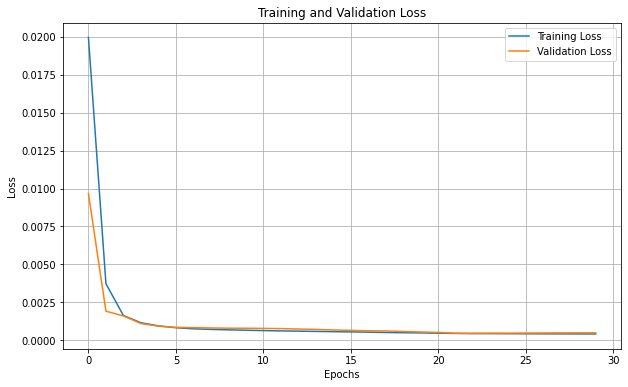

In [26]:
plot_losses(train_losses, val_losses)

#### **Evaluation on 2023 data**

In [27]:
mse_values, rmse_values, mape_values = test_model(model, test_loader, predict_scaler)

Output 1: MSE: 17839.8115, RMSE: 133.5658, MAPE: 0.0119%
Output 2: MSE: 27654.8960, RMSE: 166.2976, MAPE: 0.0147%
Output 3: MSE: 36388.6737, RMSE: 190.7582, MAPE: 0.0171%
Output 4: MSE: 45742.5455, RMSE: 213.8751, MAPE: 0.0193%


In [28]:
y_true, y_pred = get_predictions(model, test_loader)
y_true, y_pred = y_true.reshape(-1) , y_pred.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred = predict_scaler.inverse_transform(y_pred.reshape(-1,1))


C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


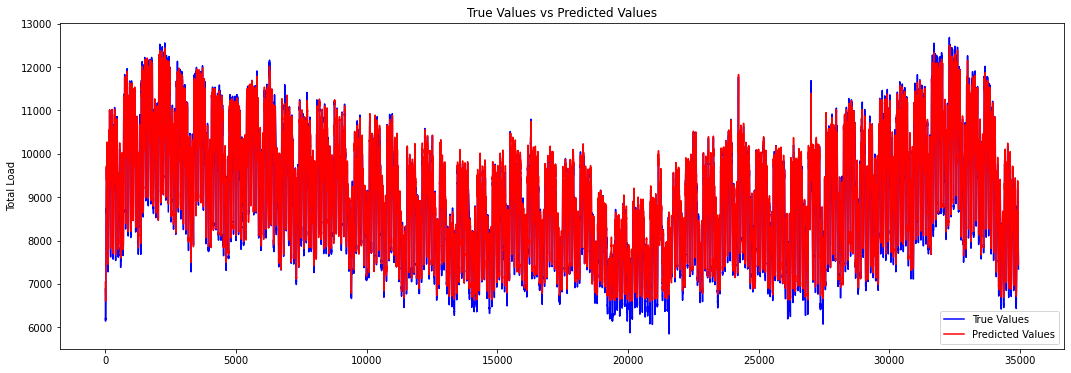

In [29]:
plot_true_vs_predicted(y_true, y_pred)

### **Evaluation on the last month of 2024**

In [30]:
# evaluation on final Test
mse_values, rmse_values, mape_values = test_model(model, final_test_loader, predict_scaler)

Validation:   0%|          | 0/6 [00:00<?, ?it/s]C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
                                                 

Output 1: MSE: 16677.1903, RMSE: 129.1402, MAPE: 0.0125%
Output 2: MSE: 26515.7384, RMSE: 162.8365, MAPE: 0.0158%
Output 3: MSE: 37127.1880, RMSE: 192.6842, MAPE: 0.0189%
Output 4: MSE: 51729.8098, RMSE: 227.4419, MAPE: 0.0225%


In [31]:
y_true, y_pred = get_predictions(model, final_test_loader)
y_true, y_pred = y_true.reshape(-1) , y_pred.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred = predict_scaler.inverse_transform(y_pred.reshape(-1,1))


C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


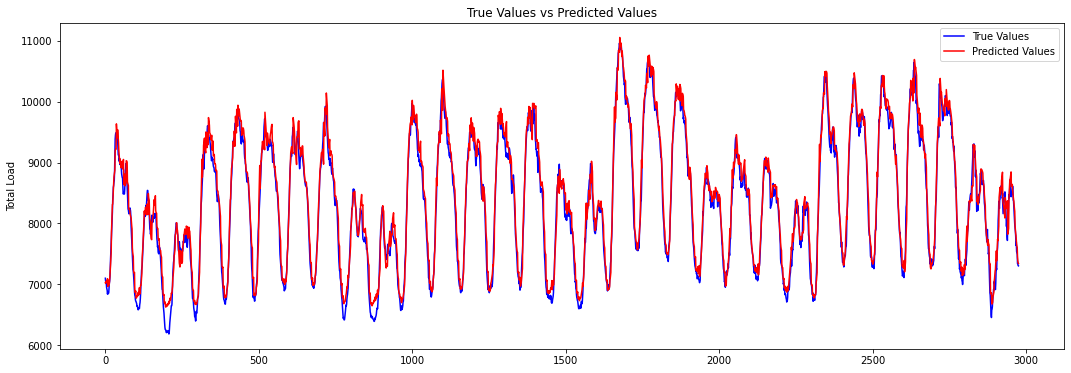

In [32]:
plot_true_vs_predicted(y_true, y_pred)

In [33]:
# saving prediction to csv file
pd.DataFrame(y_pred, columns=['Prediction']).to_csv('mlp_result.csv',index=False)

In [34]:
predictions = pd.read_csv('mlp_result.csv')
truth = pd.read_csv("truth.csv")

t0_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4]))
t1_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4]))
t2_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4]))
t3_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4]))

t0_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4])
t1_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4])
t2_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4])
t3_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4])

print("|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|")
print("| |", str(t0_rmse)[:7], "|", str(t1_rmse)[:7], "|", str(t2_rmse)[:7], "|", str(t3_rmse)[:7],
      "|", str(t0_mape)[:7], "|", str(t1_mape)[:7], "|", str(t2_mape)[:7], "|", str(t3_mape)[:7], "|", sep="")

|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |129.140|162.836|192.684|227.441|0.01251|0.01576|0.01885|0.02253|
